# NYC Yellow Taxi Growth

#### The objectives of this program:
Using the data set that comes from NYC open data of **NYC Yellow Taxi Service** and **Uber Taxi Service** we would like to **analyze the growth** of the NYC Yellow Taxi Service by using the amount of pickups done daily.

We will be using correlation between taxi and uber in respective borough to observe the **correlation between the growth rate** of both taxi and uber to help understand how competition impacts pickup amounts. We will also use statistics to help **predict the growth** done within the next few days. We will be using **histograms and line charts** to demonstrate the growth.

In [2]:
sc

In [3]:
# imports
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import matplotlib.pyplot as plt
import datetime
import csv

## Taxi vs Uber

In [4]:
taxi_aug14 = sc.textFile('../taxi_aug14_200k.csv'   , use_unicode=False).filter(lambda x: x != "").cache()
uber_aug14 = sc.textFile('../uber-raw-data-aug14.csv', use_unicode=False).cache()
# list(enumerate(taxi_aug14.first().split(',')))
# list(enumerate(uber_aug14.first().split(',')))

### Borough Estimation

We will be using midpoints of each respective boughs to where the coordinates of the bus data lies.  
We will use the a default distance of 20 miles as the maximum value away from the midterm (that is Staten Island or Manhattan) ends up being around 20 miles.  
If both borough overlap we will use the closest distance. Otherwise, if it doesn't fall in borough distance we will consider it to be outside NYC.

In [5]:
queensCenter = ((40.800760+40.542920)/2,(-73.700272-73.962616)/2)
brookCenter = ((40.739877+40.57042)/2,(-73.864754-74.04344)/2)
bronxCenter = ((40.915255+40.785743)/2,(-73.765274-73.933406)/2)
manhattanCenter = ((40.874663+40.701293)/2,(-73.910759-74.018721)/2)
siCenter = ((40.651812+40.477399)/2,(-74.034547-74.259090)/2)

boroughDict = {}
boroughDict["queens"] = queensCenter
boroughDict["brooklyn"] = brookCenter
boroughDict["bronx"] = bronxCenter
boroughDict["manhattan"] = manhattanCenter
boroughDict["staten"] = siCenter

def get_closest_borough(latitude,longitude,max_dist = 20):
    global boroughDict
    borough_distances = {borough:great_circle(boroughDict[borough],(latitude,longitude)).miles for borough in boroughDict}
    min_borough = min(borough_distances, key=borough_distances.get)
    if borough_distances[min_borough] < max_dist:
        return min_borough 
    else:
        return "outside_nyc"

### Data Ingestion for August 2014 Taxi Data

We will clean the data into:  
```((boro, pickup, 1)```  
Then we will group this data as:  
```[boro [(date, count)]]```

In [6]:
def extractTaxi(partId, records):
    if partId==0:
        records.next()
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[1].split(" ")[0], get_closest_borough(row[6],row[5]))
        yield ((boro, pickup) , 1)

trdd = taxi_aug14.mapPartitionsWithIndex(extractTaxi)\
                .reduceByKey(lambda x, y: x+y)\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y))
#trdd.take(10)

Py4JJavaError: An error occurred while calling o36.partitions.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/C:/Users/Dave/Documents/2018Spring/big_data/notebook/taxi_aug14_200k.csv
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:285)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:228)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:313)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:202)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:252)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:250)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:250)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:252)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:250)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:250)
	at org.apache.spark.api.python.PythonRDD.getPartitions(PythonRDD.scala:53)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:252)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:250)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:250)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)


### Data Ingestion for August 2014 Uber Data

Just like the taxi data, we will format the Uber data just the same.

In [7]:
def extractUber(partId, records):
    if partId==0:
        records.next()
    import csv
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[0].split(" ")[0],  get_closest_borough(row[1],row[2]))
        yield ((boro, pickup), 1)

urdd = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y))             
#urdd.take(10)

### Getting Uber Data from Respective Boroughs

We will preparing this data for data analsis.

In [8]:
data_uber = urdd.collect()
data_uber_bronx = data_uber[0][1][:]
data_uber_brooklyn = data_uber[1][1][:]
data_uber_outside_nyc = data_uber[2][1][:]
data_uber_queens = data_uber[3][1][:]
data_uber_manhattan = data_uber[4][1][:]
data_uber_staten = data_uber[4][1][:]
#print(data_uber_bronx[:10])
#, data_uber_brooklyn[:10], data_uber_outside_nyc[:10], data_uber_queens[:10], data_uber_manhattan[:10]

##### Uber Data Stored in Array

This will have the following format:  
```udata[boros[day 1 count, day 2 counts,...]]```

In [10]:
uboros = [data_uber_bronx, data_uber_brooklyn, data_uber_outside_nyc, data_uber_queens, data_uber_manhattan, data_uber_staten]
udata = [[] for y in range(6)] 
counter = 0
for boro in uboros:
    for i in boro:
        udata[counter].append(i[1])
    counter += 1

In [11]:
'''import datetime
# count =0
for b in allUber:
    bt = datetime.datetime.strptime(b, "%Y-%m-%d %H:%M:%S")
    for t in lTaxi:
        tt = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
        diff = (bt-tt).total_seconds();
        if diff > 0 and diff<600:
            count+=1
            break
print(count)'''

'import datetime\n# count =0\nfor b in allUber:\n    bt = datetime.datetime.strptime(b, "%Y-%m-%d %H:%M:%S")\n    for t in lTaxi:\n        tt = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S")\n        diff = (bt-tt).total_seconds();\n        if diff > 0 and diff<600:\n            count+=1\n            break\nprint(count)'

### Cumilative Line Graph for Uber

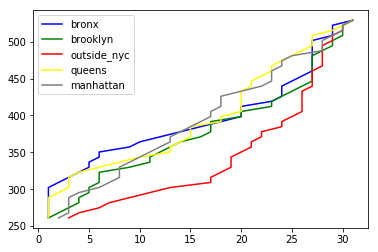

In [13]:
# evaluate the histogram
values1, base1 = np.histogram(udata[0], bins=40)
values2, base2 = np.histogram(udata[1], bins=40)
values3, base3 = np.histogram(udata[2], bins=40)
values4, base4 = np.histogram(udata[3], bins=40)
values5, base5 = np.histogram(udata[4], bins=40)
#evaluate the cumulative
cumulative1 = np.cumsum(values1)
cumulative2 = np.cumsum(values2)
cumulative3 = np.cumsum(values3)
cumulative4 = np.cumsum(values4)
cumulative5 = np.cumsum(values5)
# plot the cumulative function

plt.plot(cumulative1, base1[:-1], c='blue', label ='bronx')
plt.plot(cumulative2, base1[:-1], c='green', label ='brooklyn')
plt.plot(cumulative3, base1[:-1], c='red', label ='outside_nyc')
plt.plot(cumulative4, base1[:-1], c='yellow', label ='queens')
plt.plot(cumulative5, base1[:-1], c='grey', label ='manhattan')
plt.legend(loc='best')
plt.show()

## Growth Rate Comparison

Then we will make growth rate comparison using histograph of boro based in seperate squares to get a better idea of increase and decrease correlation for both statistics.

In [ ]:
ug_rate = map(lambda x: (reduce(lambda y, z: (z-y)/float(z)), x, []), udata)